

### **Домашнее задание**
В этом задании вам предстоит обучить свой собственный классификатор биологического гендера человека по аудиозаписи (спектрограмме). На [семинаре](https://vk.cc/atRKR8) 9 мая мы разобрали, как построить спектрограмму и подать ее в нейросеть, а также написали бейзлайн решение на Keras. 

### Задание 1 (20% баллов)
Взяв данные с семинара из датасета TIMIT (библиотека для работы с ним и подготовки данных также есть в семинаре) натренировать сетку так, чтобы на тестовой выборке accuracy_score был больше 0.97. Возможные исследования: conv1d vs conv2d, batch norm, предобученные сетки из `Imagenet`. Обязательно напишите, что вы использовали и какой вывод. Писать можно на любом фреймворке. 
### Задание 2 (30% баллов)
Подумайте, как бы можно было "испортить" данные для тестовой выборки и впоследствии попробовать восстановить скор при помощи аугментаций трейнсета и усложнения архитектуры? Используя данные из `TEST` усложните выборку и посмотрите, как упадет accuracy_score. Следите, чтобы он не падал ниже 70 -- есть риск тогда не обучиться совсем. Вдохновиться аудио аугментациями можно например [здесь](https://vk.cc/atRLgR). Почитать про то, как еще аугментируют данные, но уже на уровне спектрограмм можно [в блоге Google AI](https://vk.cc/9jCCnk). Посмотрите, какие аугментации влияют сильнее всего? На этом этапе мы пока ничего не учим, а только пытаемся испортить скор бейзлайна с семинара.
### Задание 3 (40% баллов)
При помощи изложенных в предыдущем пункте средств, а также идей и хинтов с семинара, постарайтесь улучшить скор модели на "испорченных" данных. Можно делать все, кроме обучения на тесте :). 
### Задание 4 (10% баллов)
Напишите вывод -- если попробовали какие-то архитектуры, аугментации, но это не помогло, тоже обязательно напишите. Расскажите, что пробовали, и что оказалось самым боевым. Здесь будет релевантно сделать таблицу.

Дополнительные материалы и ссылки:
1. [Текстом про то, как делается преобразование в мел-спектрограмму](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9)
2. [Соревнование по классификации голосовых команд](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)
3. [Данные для распознавания речи на русском языке](https://github.com/snakers4/open_stt)
4. [Проект по генерации музыки](https://openai.com/blog/jukebox/)
5. [Опенсорс-проект по разделению песни на минус и вокал](https://github.com/deezer/spleeter)
6. [wav2vec](https://arxiv.org/abs/1904.05862)
7. [Лекция 
Microsoft Research
 про историю Automatic Speech Recognition](https://www.youtube.com/watch?v=q67z7PTGRi8)
8. [Transformer для генерации музыки](https://openai.com/blog/musenet/)
9. [Библиотека, содержащая в себе api для распознавания речи (Google, Microsoft, ...)](https://pypi.org/project/SpeechRecognition/)

In [2]:
!wget https://ndownloader.figshare.com/files/10256148


--2020-06-09 02:53:31--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.49.200.187, 34.243.191.39, 34.247.146.8, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.49.200.187|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2020-06-09 02:53:31--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.108.211
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.108.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148’

10256148            100%[===================>] 419.81M  30.9MB/s    in 14s     

2020-06-09 02:53:46 (29.2 MB/s) - ‘10256148’ saved [440207227/440207227]



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
import keras, keras.layers
from keras.callbacks import EarlyStopping

%matplotlib inline


Using TensorFlow backend.


In [0]:
# fix randoms

rnd = 383

from numpy.random import seed
import random
random.seed(rnd)
seed(rnd)


In [0]:
!unzip -q 10256148


In [6]:
!pip -q install timit-utils


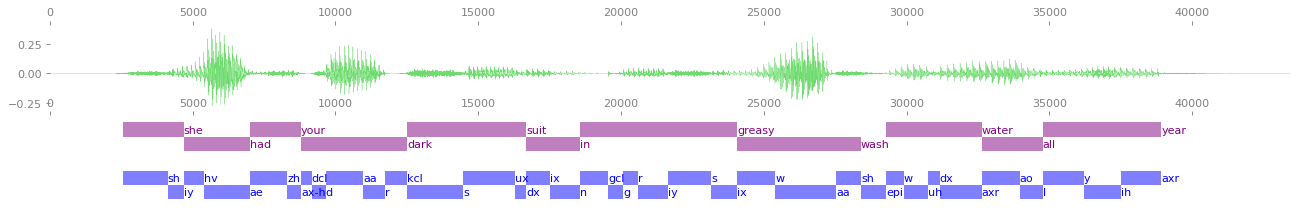

In [7]:
%matplotlib inline
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])

IPython.display.Audio(sentence.raw_audio, rate=16000)


In [0]:
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)


In [0]:
person_1 = corpus.train.person_by_index(100)


In [10]:
person_1.name


'DPS0'

In [11]:
Speakers_info.return_sex(person_1.name)


'M'

In [12]:
IPython.display.Audio(person_1.sentence_by_index(1).raw_audio, rate=16000)


In [0]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]


In [0]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft


In [0]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram


In [0]:
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='reflect')
    target = 0 if gender == 'F' else 1
    return np.float32(spectrogram), np.int64(target)


Создадим тестсет и трейнсет из данных для `TIMIT` 

In [0]:
def create_dataset(mode='train'):
    assert mode in ['train','test']
    if mode == 'train':
        people = [corpus.train.person_by_index(i) for i in range(400)]
    if mode == 'test':
        people = [corpus.test.person_by_index(i) for i in range(150)]
    spectrograms_and_targets = []
    for person in tqdm_notebook(people): 
        target = Speakers_info.return_sex(person.name)
        for i in range(len(person.sentences)):
            spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
    return spectrograms_and_targets


In [18]:
trainset = create_dataset('train')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
X, y = map(np.stack, zip(*trainset))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=rnd)


In [21]:
X_train.shape


(3000, 150, 128)

In [22]:
dropout_rate = .2

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(None, 128)), 
    keras.layers.Conv1D(128, kernel_size=3), keras.layers.Activation('relu'),
    keras.layers.Dropout(dropout_rate),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5), keras.layers.Activation('relu'),
    keras.layers.Dropout(dropout_rate),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(32, kernel_size=7), keras.layers.Activation('relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
activation_1 (Activation)    (None, None, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          41024     
_________________________________________________________________
activation_2 (Activation)    (None, None, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)         

In [31]:
model.compile('adam', 'sparse_categorical_crossentropy',
          metrics = ['sparse_categorical_accuracy'])
model.fit(X_train, y_train, epochs=30,
          validation_data = [X_val, y_val],
          callbacks = [EarlyStopping(patience = 5)])


Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0314 - val_sparse_categorical_accuracy: 0.9920
Epoch 2/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0514 - val_sparse_categorical_accuracy: 0.9890
Epoch 3/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9920
Epoch 4/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0053 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.1144 - val_sparse_categorical_accuracy: 0.9780
Epoch 5/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0031 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0330 - val_sparse_categorical_accuracy: 0.9920
Epoch 6/30
3000/3000 [===============

In [32]:
testset = create_dataset('test')
X_test, y_test = map(np.stack, zip(*testset))
X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [33]:
len(X_test)


1500

In [0]:
y_pred = model.predict_classes(X_test)


In [35]:
# accuracy
sum(y_pred==y_test)/len(X_test)


0.986

In [36]:
accuracy_score(y_pred, y_test)
# Conv1D, no batchnorm, no dropout, sgd, no callbacks   .9593333333333334
# Conv1D, batchnorm, dropout, adam, no callbacks        .9886666666666667
# то ли дело в сиде, то ли EarlyStopping ухудшает процент верных ответов для теста
# Conv1D, batchnorm, dropout, adam, callbacks           .9826666666666667
# Conv1D, no batchnorm, dropout, adam, callbacks        .9726666666666667
# Conv1D, batchnorm, no dropout, adam, callbacks        .9753333333333334
# Conv1D layers from 256 to 1024, batchnorm=.3, elu     .9753333333333334


0.986

In [0]:
# Сохранение модели
model.save('model.h5')
# # Восстановим в точности ту же модель, включая веса и оптимизатор
# new_model = keras.models.load_model('model.h5')


In [205]:
model_c = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(150, 128, 1)), 
    keras.layers.Conv2D(16, (3, 3), activation='elu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='elu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='elu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='sigmoid'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='softmax')
])

model_c.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 148, 126, 16)      160       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 74, 63, 16)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 72, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 36, 30, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 34, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 17, 14, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 15, 12, 32)      

In [206]:
X_train.shape, np.expand_dims(X_train, axis=-1).shape


((3000, 150, 128), (3000, 150, 128, 1))

In [0]:
# model = getModel()
# model.summary()

# batch_size = 32

# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

# model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=0, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

In [208]:
# opt = keras.optimizers.Adam(learning_rate=3e-3)
model_c.compile('adam', 'sparse_categorical_crossentropy',
          metrics = ['sparse_categorical_accuracy'])
model_c.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=33,
            validation_data = [np.expand_dims(X_val, axis=-1), y_val],
            callbacks = [EarlyStopping(patience = 5)])


Train on 3000 samples, validate on 1000 samples
Epoch 1/33
3000/3000 [==============================] - 65s 22ms/step - loss: 0.4094 - sparse_categorical_accuracy: 0.8197 - val_loss: 0.1394 - val_sparse_categorical_accuracy: 0.9540
Epoch 2/33
3000/3000 [==============================] - 65s 22ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.0992 - val_sparse_categorical_accuracy: 0.9660
Epoch 3/33
3000/3000 [==============================] - 67s 22ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.0741 - val_sparse_categorical_accuracy: 0.9720
Epoch 4/33
3000/3000 [==============================] - 65s 22ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.0669 - val_sparse_categorical_accuracy: 0.9750
Epoch 5/33
3000/3000 [==============================] - 65s 22ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9730
Epoch 6/33
3000/3000 [==========

In [0]:
# testset = create_dataset('test')
# X_test, y_test = map(np.stack, zip(*testset))
# X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]

In [0]:
# len(X_test)

In [0]:
y_pred = model_c.predict_classes(np.expand_dims(X_test, axis=-1))


In [212]:
y_pred.shape, y_test.shape


((1500,), (1500,))

In [213]:
# accuracy
sum(y_pred==y_test)/len(X_test)


0.984

In [214]:
accuracy_score(y_pred, y_test)
# 2 Conv2D layers 64, (3, 3), activation='relu'                                 .973
# 3 Conv2D layers 16, 32, 64, (3, 3), activation='elu'                          .975
# 3 Conv2D layers 32, 64, 128, BatchNormalization, activation='relu', lr=3e-4   .9773333333333334


0.984

In [0]:
# Сохранение модели
model_c.save('model_c_984.h5')
# # Восстановим в точности ту же модель, включая веса и оптимизатор
# new_model = keras.models.load_model('model_c.h5')


Простые идеи для улучшения классификатора (представим, что решаем задачу посложнее):
1. 1d or 2d convolutions + batchnorm
2. VGG-like, residual
3. Upper batch size
4. Data augmentation (background noise? jitter? freq?)
5. Denoising?

### Часть 3
усложняем себе жизнь -- добавим шумов в данные и посмотрим как получится

In [0]:
def spoil_with_noise(data, noise_factor=0.02):
    noise = np.random.normal(size=len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data
    

In [0]:
test_wav = person_1.sentence_by_index(0).raw_audio


In [218]:
IPython.display.Audio(spoil_with_noise(person_1.sentence_by_index(0).raw_audio), rate=16000)


In [0]:
def spoil_dataset(mode='train'):
    assert mode in ['train','test']
    if mode == 'train':
        people = [corpus.train.person_by_index(i) for i in range(400)]
    if mode == 'test':
        people = [corpus.test.person_by_index(i) for i in range(150)]
    spectrograms_and_targets = []
    for person in tqdm_notebook(people): 
        target = Speakers_info.return_sex(person.name)
        for i in range(len(person.sentences)):
            spectrograms_and_targets.append(preprocess_sample(spoil_with_noise(person.sentence_by_index(i).raw_audio),target))
    return spectrograms_and_targets


In [0]:
def speed_change(data, speed_factor=0.5):
    return librosa.effects.time_stretch(data, speed_factor)
    

In [221]:
speed_change(test_wav)


array([2.88025191e-04, 3.31737808e-05, 3.34295750e-05, ...,
       5.61410034e-05, 6.70315687e-05, 5.99620911e-05])

In [222]:
testset = spoil_dataset('test')
X_test, y_test = map(np.stack, zip(*testset))
X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [226]:
# Conv1D model

accuracy_score(model.predict_classes(X_test),y_test)


0.6573333333333333

In [227]:
# Conv2D model

accuracy_score(model_c.predict_classes(np.expand_dims(X_test, axis=-1)),y_test)


0.938

Как видим, модель на 2d-свертках показывает очень неплохой результат в задачке классификации испорченных звуков. Была еще гипотеза сделать автоэнкодер, натренировать его с подсчетом ошибки м-ду испорченным трейном и не испорченным и последующим добавлением классифицируечих слоев (Flatten(), Dense(softmax)). Думаю, сработает неплохо. Но лучшее - враг хорошего, 
да и дедлайн близок.

## Вывод
* Модель на 1D-свертках.
    + Добавление dropout=.2 и batch normalization скор улучшает
    + Изменение dropout - ухудшает
    + То ли дело в сиде, то ли EarlyStopping ухудшает процент верных ответов для теста. В этой модели от callbacks отказался.
    + Сразу поставил adam => скор улучшился. Игры с adamax и др. оптимизаторами, а также с изменением learning rate либо не влияют, либо ухудшают результат.
    + Пробовал разное кол-во фильтров в слоях, менял relu на elu, результат не улучшается
* Модель на 2D-свертках.
    + Были сложности с размерностями, но победил, да без подсказок, что радует.
    + Dropout и batch normalization тут не работют, но я с этим уже встречался, потому рез-т не удивил.
    + Вместо GlobalAveragePooling1D поставил MaxPooling2D для каждого слоя сверток. Но вот сейчас пишу и думаю, что, наверное, GlobalAveragePooling2D, отработал бы так же хорошо.
    + Пробовал разные конфигурации и по количеству сверток, и по количеству фильтров, и по активациям. На первых свертках лучше работает elu (пробовал relu), на последней - sigmoid (пробовал relu, tanh), между Flatten()-слоем и последним классификатором-softmax ставил полносвязный слой, но это привело к ухудшению результата, да еще увеличило на порядок кол-во тренируемых параметров с сообветствующим увеличением времени тренировки модели.
    + В итоге победила модель с ростом кол-ва фильтров на свертках с 16 до 128, а последняя свертка на 32 фильтроа. Это и результат дало лучший, чем, если бы последняя свертка имела большее кол-во фильтров, и тренируется быстрей из-за уменьшения числа тренируемых параметров модели.
    + Скор вполне сравнимы с предыдущей моделью (0.984 против 0.9887 на 1d-свертках). То же можно сказать и о времени обученния.
* Улучшение скора модели на "испорченных" данных. 
    + Модель на 2d-свертках показывает очевидно неплохой результат (0.938 против 0.657 на 1d-свертках) в задачке классификации испорченных данных.
    + Была еще гипотеза сделать автоэнкодер, натренировать его с подсчетом ошибки м-ду испорченным трейном и не испорченным и последующим добавлением классифицирующих слоев (Flatten(), Dense(softmax)). Думаю, сработает неплохо. Но лучшее - враг хорошего, да и дедлайн близок.